In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

In [ ]:
# ==== Carregar e preparar dados ====

arquivo = "/content/Dados Históricos - Bitcoin.csv"
df = pd.read_csv(arquivo)

df.columns = [c.strip() for c in df.columns]
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)


df['Último'] = (
    df['Último'].astype(str)
    .str.replace('.', '', regex=False)
    .str.replace(',', '.', regex=False)
    .astype(float)
)

df = df.sort_values("Data").reset_index(drop=True)
df = df[(df['Data'] >= '2019-01-08') & (df['Data'] <= '2025-10-08')].reset_index(drop=True)

# ==== Separar treino / teste ====
train = df[(df['Data'] >= '2019-01-08') & (df['Data'] <= '2024-12-31')]
test  = df[(df['Data'] >= '2025-01-08') & (df['Data'] <= '2025-10-08')]

y_train = train['Último']
y_test_real = test['Último'].values
dates_test = test['Data'].values

In [ ]:
# Treinar ARMA
p, d, q = 2, 0, 5
modelo = ARIMA(y_train, order=(p, d, q))
ajuste = modelo.fit()


# Previsão para o período de teste
steps = len(test)
y_pred_base = ajuste.forecast(steps=steps).values


#Ajuste adaptativo de drift
residuals = y_test_real - y_pred_base

# estimativa do drift/ média móvel dos resíduos
drift_window = 15
drift_est = pd.Series(residuals).rolling(window=drift_window, min_periods=1).mean().values


y_pred_adjusted = y_pred_base + drift_est


y_pred_final = pd.Series(y_pred_adjusted).rolling(window=5, min_periods=1).mean().values

In [ ]:
# Métricas (base x ajustado)
rmse_base = np.sqrt(mean_squared_error(y_test_real, y_pred_base))
rmse_final = np.sqrt(mean_squared_error(y_test_real, y_pred_final))

mape_base = mean_absolute_percentage_error(y_test_real, y_pred_base) * 100
mape_final = mean_absolute_percentage_error(y_test_real, y_pred_final) * 100

r2_base = r2_score(y_test_real, y_pred_base)
r2_final = r2_score(y_test_real, y_pred_final)

abs_error_base = np.abs(y_test_real - y_pred_base)
abs_error_final = np.abs(y_test_real - y_pred_final)

print("\nMétricas (ARMA):")
print(f"RMSE Base: {rmse_base:.4f}  | RMSE Ajustado: {rmse_final:.4f}")
print(f"MAPE Base: {mape_base:.2f}% | MAPE Ajustado: {mape_final:.2f}%")
print(f"R² Base: {r2_base:.4f}     | R² Ajustado: {r2_final:.4f}")


# Tabela de comparação
comparacao = pd.DataFrame({
    'Data': dates_test,
    'Real': y_test_real,
    'Previsto_ARMA_Base': y_pred_base,
    'Previsto_ARMA_Ajustado': y_pred_final,
    'ErroAbs_Base': abs_error_base,
    'ErroAbs_Ajustado': abs_error_final,
    'DifPerc_Ajustado': (y_pred_final - y_test_real) / y_test_real * 100
})
comparacao.to_csv("Previsoes_NVDA_ARMA_Ajustado.csv", index=False)
print("\nPrimeiras linhas da comparação:")
print(comparacao.head(10))


Métricas (ARMA):
RMSE Base: 16769.5006  | RMSE Ajustado: 4486.3243
MAPE Base: 13.38% | MAPE Ajustado: 3.52%
R² Base: -0.9548     | R² Ajustado: 0.8601

Primeiras linhas da comparação:
        Data      Real  Previsto_ARMA_Base  Previsto_ARMA_Ajustado  \
0 2025-01-08   95066.6        93518.927873            95066.600000   
1 2025-01-09   92539.8        93479.436977            94425.027276   
2 2025-01-10   94724.1        93401.520765            94298.371148   
3 2025-01-11   94612.0        93419.650761            94273.876278   
4 2025-01-12   94541.8        93425.196322            94273.722979   
5 2025-01-13   94536.1        93410.377395            94121.321455   
6 2025-01-14   96542.1        93399.860342            94287.674886   
7 2025-01-15  100499.8        93388.437556            94546.822919   
8 2025-01-16  100004.5        93377.208476            94876.545915   
9 2025-01-17  104084.9        93365.940986            95354.415006   

   ErroAbs_Base  ErroAbs_Ajustado  DifPerc_A

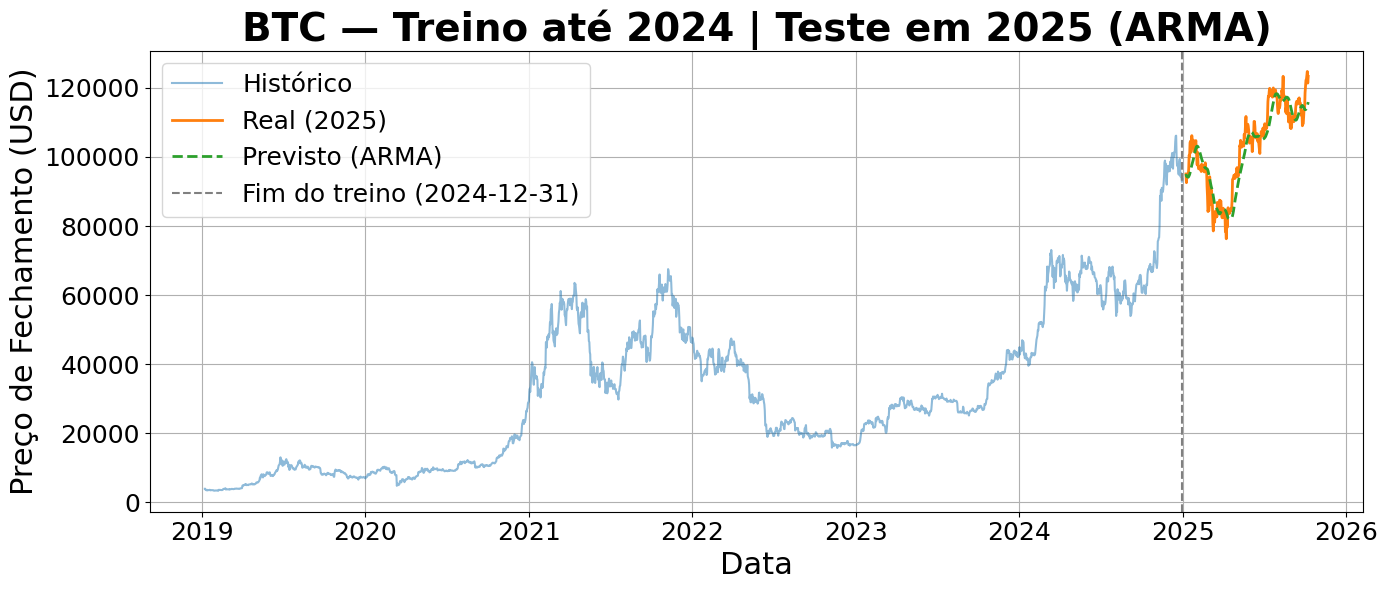

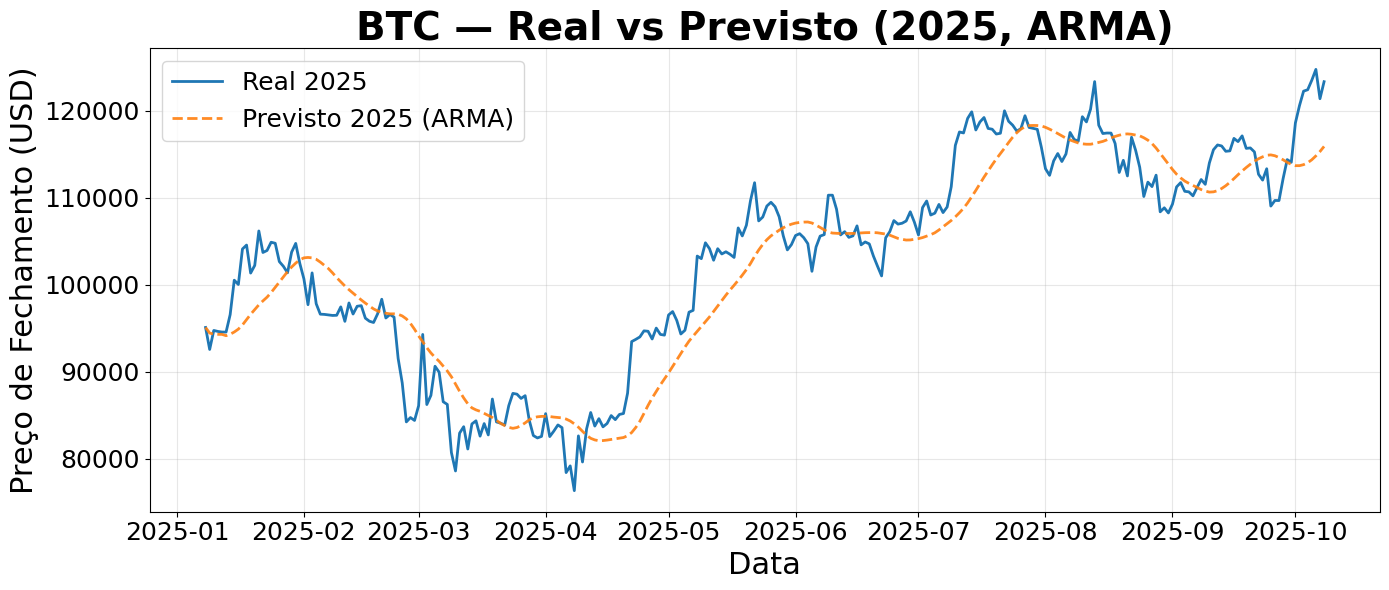

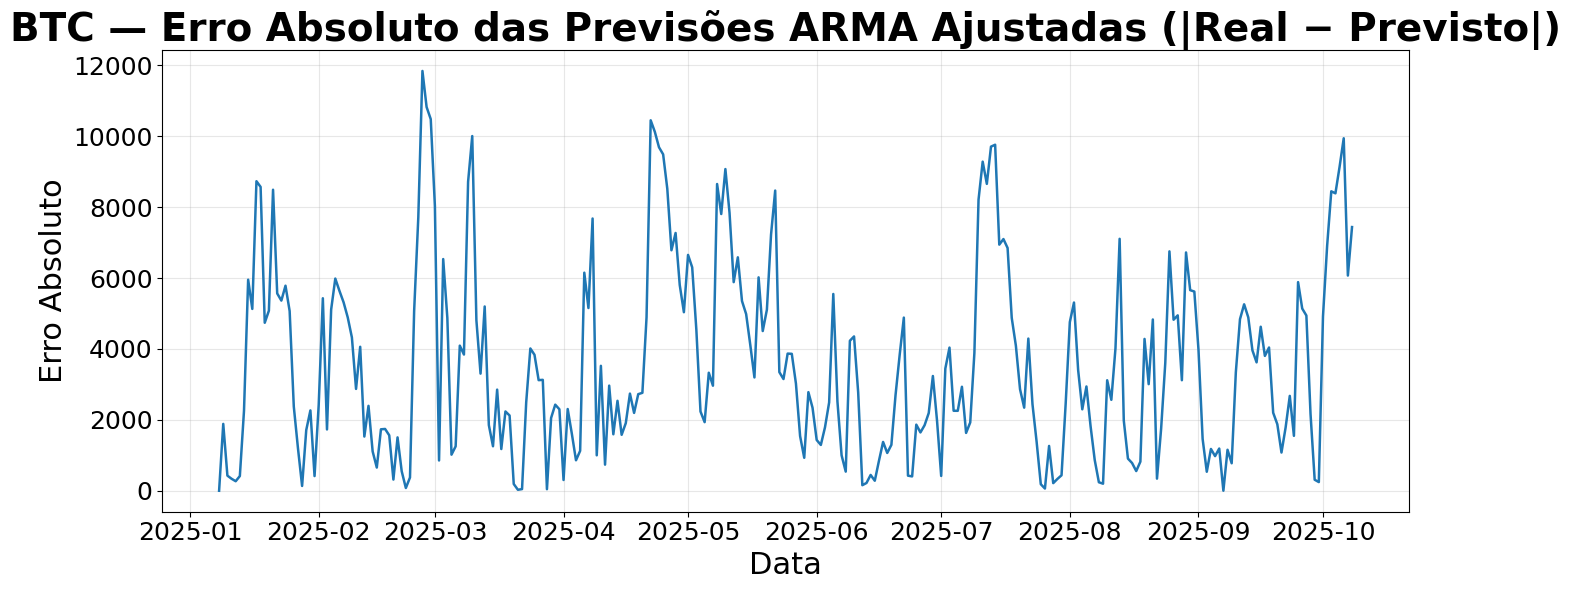

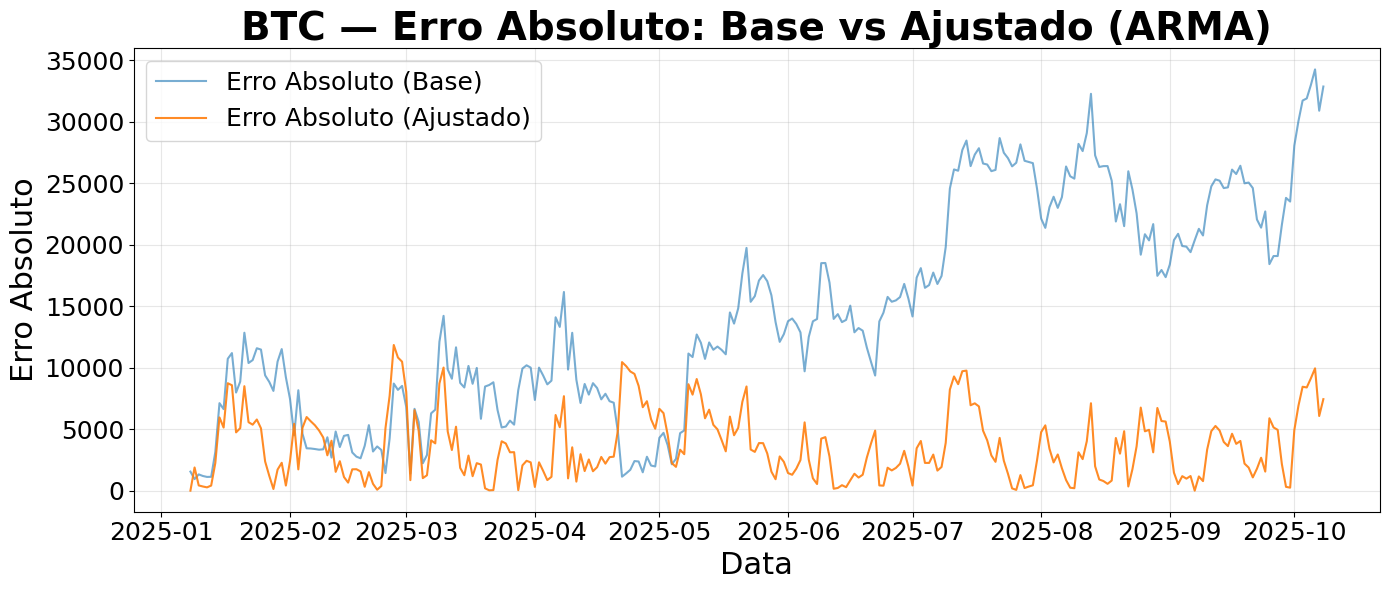


Arquivo 'Previsoes_BTC_ARMA_Ajustado.csv' salvo com sucesso.


In [ ]:
# 8. Gráficos

train_end = pd.Timestamp('2024-12-31')

# Histórico + Real vs Previsto Ajustado
plt.figure(figsize=(14,6))
plt.plot(train['Data'], train['Último'], label='Histórico', alpha=0.5)
plt.plot(dates_test, y_test_real, label='Real (2025)', linewidth=2)
plt.plot(dates_test, y_pred_final, label='Previsto (ARMA)', linewidth=2, linestyle='--')
plt.axvline(train_end, color='gray', linestyle='--', label='Fim do treino (2024-12-31)')

plt.title('BTC — Treino até 2024 | Teste em 2025 (ARMA)', fontsize=28, weight='bold')
plt.xlabel('Data', fontsize=22)
plt.ylabel('Preço de Fechamento (USD)', fontsize=22)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()


# Comparativo base vs ajustado
plt.figure(figsize=(14,6))
plt.plot(dates_test, y_test_real, label='Real 2025', linewidth=2)
#plt.plot(dates_test, y_pred_base, label='Previsto Base', linewidth=2, linestyle='--', alpha=0.5)
plt.plot(dates_test, y_pred_final, label='Previsto 2025 (ARMA)', linewidth=2, linestyle='--', alpha=0.9)

plt.title('BTC — Real vs Previsto (2025, ARMA)', fontsize=28, weight='bold')
plt.xlabel('Data', fontsize=22)
plt.ylabel('Preço de Fechamento (USD)', fontsize=22)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=18)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Gráfico do Erro Absoluto (Ajustado)
plt.figure(figsize=(14,6))
plt.plot(dates_test, abs_error_final, linewidth=1.8)

plt.title('BTC — Erro Absoluto das Previsões ARMA Ajustadas (|Real − Previsto|)', fontsize=28, weight='bold')
plt.xlabel('Data', fontsize=22)
plt.ylabel('Erro Absoluto', fontsize=22)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Gráfico comparativo do erro absoluto (base vs ajustado)
plt.figure(figsize=(14,6))
plt.plot(dates_test, abs_error_base, label='Erro Absoluto (Base)', alpha=0.6)
plt.plot(dates_test, abs_error_final, label='Erro Absoluto (Ajustado)', alpha=0.9)

plt.title('BTC — Erro Absoluto: Base vs Ajustado (ARMA)', fontsize=28, weight='bold')
plt.xlabel('Data', fontsize=22)
plt.ylabel('Erro Absoluto', fontsize=22)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=18)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nArquivo 'Previsoes_BTC_ARMA_Ajustado.csv' salvo com sucesso.")
